In [1]:
import torch
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torchvision.utils import save_image
import copy


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
def load_image(img_path, max_size=720, shape=None):
    image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])

    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image.clamp(0, 1))
    return image


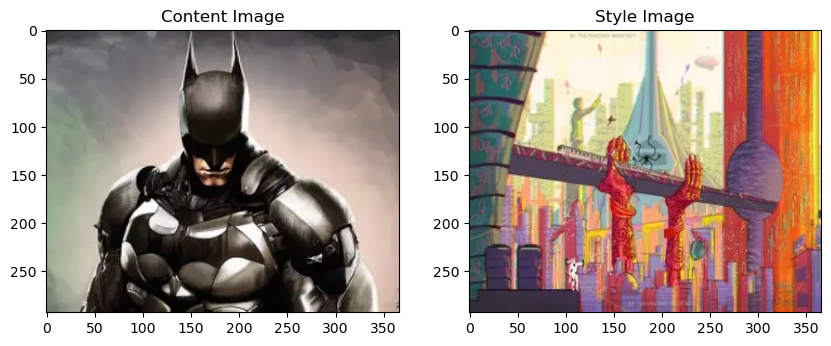

In [15]:
# File paths
content_path = "2.jpg"
style_path = "1.jpg"

# Load for low-res training
content = load_image(content_path).to(device)
style = load_image(style_path, shape=[content.size(2), content.size(3)]).to(device)

# Show low-res versions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image")
ax2.imshow(im_convert(style))
ax2.set_title("Style Image")
plt.show()



In [5]:
vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

def get_features(image, model=vgg):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',  # Content layer
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


In [6]:
style_weights = {
    'conv1_1': 1.,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

content_features = get_features(content)
style_features = get_features(style)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


In [7]:
def train_style(steps, lr):
    optimizer = optim.Adam([target], lr=lr)
    

    with torch.no_grad():
        content_features = get_features(content)
        style_features = get_features(style)
        style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    
    for step in range(1, steps+1):
        target_features = get_features(target)
        
        # Content loss
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
        
        # Style loss
        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (target_feature.shape[1]**2)
        
        total_loss = content_weight * content_loss + style_weight * style_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            target.clamp_(0, 1)
        
        if step % 50 == 0:
            print(f"Step {step}, Total loss: {total_loss.item():.4f}")


In [ ]:
target = content.detach().clone().requires_grad_(True).to(device)

train_style(steps=500, lr=0.003)

# Convert to PIL image
lowres_img = im_convert(target)
lowres_img.save("lowres.png")

plt.imshow(lowres_img)
plt.title("Low-res result")
plt.axis("off")
plt.show()


In [9]:
from PIL import Image

lowres_img = Image.open("lowres.png")

target_size = 1024

orig_w, orig_h = lowres_img.size

# Scale while keeping aspect ratio
if orig_w > orig_h:
    new_w = target_size
    new_h = int(target_size * (orig_h / orig_w))
else:
    new_h = target_size
    new_w = int(target_size * (orig_w / orig_h))

upscaled_img = lowres_img.resize((new_w, new_h), Image.LANCZOS)
upscaled_img.save("upscaled.png")
upscaled_img.show()
